# Mapping migration

Introduction to vector data operations

## STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [18]:
# Restore variables from previous notebook
%store -r eco_gdf gbif_gdf

:::

### Identify the ecoregion for each observation

You can combine the ecoregions and the observations **spatially** using
a method called `.sjoin()`, which stands for spatial join.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p>Check out the <a
href="https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins"><code>geopandas</code>
documentation on spatial joins</a> to help you figure this one out. You
can also ask your favorite LLM (Large-Language Model, like ChatGPT)</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Perform a spatial join</div></div><div class="callout-body-container callout-body"><p>Identify the correct values for the <code>how=</code> and
<code>predicate=</code> parameters of the spatial join.</p></div></div>

In [19]:
# Join both geodataframes together
gbif_ecoregion_gdf = (
    eco_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how='inner', 
        predicate='contains')
)

# Call joined geodataframes
gbif_ecoregion_gdf

,name,area,geometry,gbifID,month
ecoregion_id,,,,,
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",4743927038,5
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",4621947377,5
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",4761090115,6
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",5536938630,7
13.0,Alberta-British Columbia foothills forests,17.133639,"MULTIPOLYGON (((-119.53979 55.81661, -119.5443...",4630693711,6
...,...,...,...,...,...
845.0,North Atlantic moist mixed forests,5.586107,"MULTIPOLYGON (((-9.09602 52.60926, -9.07859 52...",4799252645,9
845.0,North Atlantic moist mixed forests,5.586107,"MULTIPOLYGON (((-9.09602 52.60926, -9.07859 52...",5447144262,10
845.0,North Atlantic moist mixed forests,5.586107,"MULTIPOLYGON (((-9.09602 52.60926, -9.07859 52...",4775896521,10


### Count the observations in each ecoregion each month

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Group observations by ecoregion</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Replace <code>columns_to_group_by</code> with a list of columns.
Keep in mind that you will end up with one row for each group – you want
to count the observations in each ecoregion by month.</li>
<li>Select only month/ecosystem combinations that have more than one
occurrence recorded, since a single occurrence could be an error.</li>
<li>Use the <code>.groupby()</code> and <code>.mean()</code> methods to
compute the mean occurrences by ecoregion and by month.</li>
<li>Run the code – it will normalize the number of occurrences by month
and ecoretion.</li>
</ol></div></div>

In [20]:
# Group observations by ecoregion
occurrence_df = (
    gbif_ecoregion_gdf
    # Reset index
    .reset_index()
    # For each ecoregion, for each month...
    .groupby(['ecoregion_id', 'month'])
    # Count the number of occurrences
    .agg(occurrences=('gbifID', 'count'),
    area=('area', 'mean')
)
)

# Normalize by area 
occurrence_df['density'] = (
    occurrence_df.occurrences 
    / occurrence_df.area 
)
# Get rid of rare observations (possible misidentification?)
occurrence_df = occurrence_df[occurrence_df.occurrences>1]

# Call observations by ecoregion
occurrence_df

occurrences       area     density
ecoregion_id month                                    
13.0         5                2  17.133639    0.116729
             6                2  17.133639    0.116729
             7                2  17.133639    0.116729
17.0         4                2   7.958751    0.251296
             5             3023   7.958751  379.833482
...                         ...        ...         ...
839.0        7              297  35.905513    8.271710
             8               40  35.905513    1.114035
             9               11  35.905513    0.306360
845.0        9               28   5.586107    5.012436
             10               9   5.586107    1.611140

[309 rows x 3 columns]

In [21]:
# Take the mean by ecoregion for temporal normalization for ecoregion seasonal bias
mean_occurrences_by_ecoregion = (
    occurrence_df
    .groupby('ecoregion_id')
    .mean()
)
# Call the mean by ecoregion calculated
mean_occurrences_by_ecoregion

,occurrences,area,density
ecoregion_id,,,
13.0,2.000000,17.133639,0.116729
17.0,1449.666667,7.958751,182.147515
23.0,3.000000,3.346216,0.896535
33.0,952.857143,16.637804,57.270609
34.0,248.000000,18.674884,13.279869
...,...,...,...
810.0,6.333333,5.968650,1.061100
833.0,9.000000,0.610793,14.734931
838.0,105.500000,4.286144,24.614199


In [22]:
# Take the mean by month to normalize seasonal sampling bias across months 
mean_occurrences_by_month = (
    occurrence_df
    .groupby('month')
    .mean()
)

# Call the mean by month calculated
mean_occurrences_by_month

,occurrences,area,density
month,,,
1,7.666667,71.521667,0.108516
2,7.333333,75.264253,0.087302
3,5.000000,26.659494,1.005634
4,143.527778,11.290958,17.914050
5,1226.186441,20.336924,93.909315
6,1089.048780,25.964518,66.457658
7,568.051282,25.959953,33.783154
8,167.567568,25.862437,11.698803
9,271.473684,20.046204,28.497336


### Normalize the observations

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Normalize</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Divide occurrences by the mean occurrences by month AND the mean
occurrences by ecoregion</li>
</ol></div></div>

In [23]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences'] = (
    occurrence_df[['density']]
    / mean_occurrences_by_ecoregion[['density']]
    / mean_occurrences_by_month[['density']]
)

# Call occurance data after normalization
occurrence_df

occurrences       area     density  norm_occurrences
ecoregion_id month                                                      
13.0         5                2  17.133639    0.116729          0.010649
             6                2  17.133639    0.116729          0.015047
             7                2  17.133639    0.116729          0.029601
17.0         4                2   7.958751    0.251296          0.000077
             5             3023   7.958751  379.833482          0.022206
...                         ...        ...         ...               ...
839.0        7              297  35.905513    8.271710          0.037032
             8               40  35.905513    1.114035          0.014402
             9               11  35.905513    0.306360          0.001626
845.0        9               28   5.586107    5.012436          0.053111
             10               9   5.586107    1.611140          0.076551

[309 rows x 4 columns]

<Axes: xlabel='month', ylabel='norm_occurrences'>

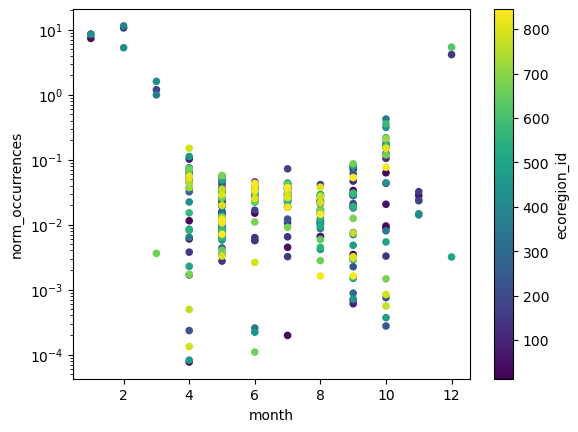

In [ ]:
# Quickly view dataframe to see how normalization looks
# Check for patterns or anomalies, label in future
occurrence_df.reset_index().plot.scatter(
    x='month', y='norm_occurrences', c='ecoregion_id',
    logy=True
)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Make sure to store the new version of your <code>DataFrame</code> for
other notebooks!</p>
<div id="f13606e9" class="cell" data-execution_count="9">
<div class="sourceCode" id="cb1"><pre
class="sourceCode python cell-code"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a><span class="op">%</span>store occurrence_df</span></code></pre></div>
</div></div></div>

# STEP -1: Wrap up

Don’t forget to store your variables so you can use them in other
notebooks! Replace `var1` and `var2` with the variable you want to save,
separated by spaces.

In [27]:
# Store variables for future use
%store occurrence_df

Stored 'occurrence_df' (DataFrame)


Finally, be sure to `Restart` and `Run all` to make sure your notebook
works all the way through!